In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision.models import vgg16_bn
import PIL

In [2]:
movie_data = Path('/scratch/bpho/datasets/movies_001/')
cropped_hr = movie_data/'roi_hr_128'
cropped_lr = movie_data/'roi_lr_128'
model_path = Path('/scratch/bpho/models')

In [3]:
def map_to_hr(x):
    hr_name = x.relative_to(cropped_lr)
    return cropped_hr/hr_name

src = (ImageImageList
        .from_folder(cropped_lr)
        .split_by_folder()
        .label_from_func(map_to_hr))

def get_data(bs, size):
    tfms = get_transforms(flip_vert=True)
    data = (src
            .transform(tfms, size=size, tfm_y=True)
            .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

In [4]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]


In [5]:
base_loss = F.l1_loss

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [6]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [11]:
bs = 64
size = 128
data = get_data(bs, size)

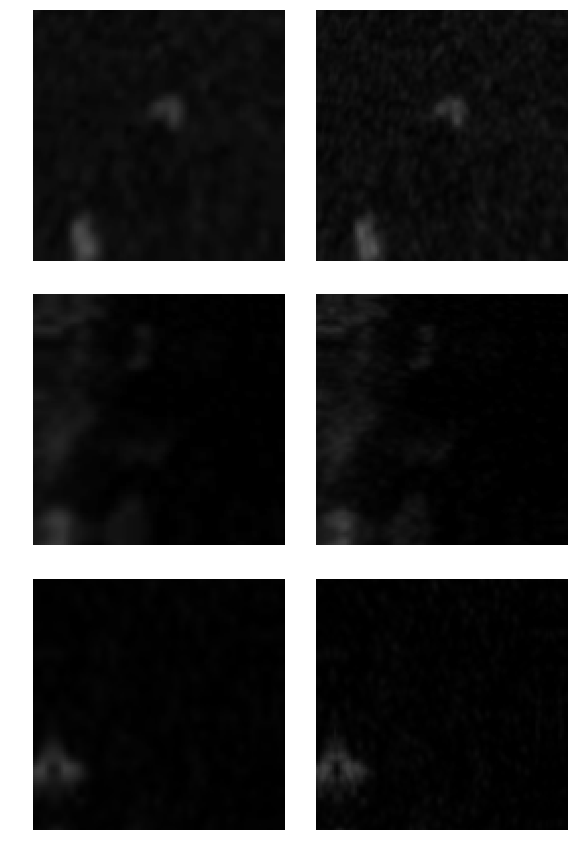

In [12]:
data.show_batch(3)

In [13]:
arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

18598

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


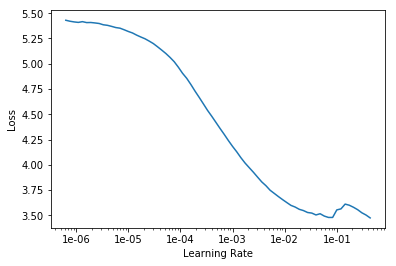

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
lr = 1e-3

In [17]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9, cycle_len=10):
    learn.fit_one_cycle(cycle_len, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=3, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,0.675170,0.715767,0.020631,0.097142,0.114417,0.018336,0.167853,0.285936,0.011453
2,0.676074,0.699574,0.020564,0.096568,0.113090,0.018092,0.161067,0.278857,0.011334
3,0.669274,0.692882,0.022638,0.096733,0.113617,0.018039,0.155633,0.274902,0.011320
4,0.670437,0.703893,0.025301,0.096810,0.113903,0.018462,0.157099,0.280638,0.011680
5,0.679305,0.690838,0.024987,0.096351,0.112392,0.017756,0.151806,0.276450,0.011095
6,0.672046,0.684364,0.020531,0.095320,0.111417,0.017511,0.158186,0.270490,0.010910
7,0.698507,0.695495,0.020901,0.095656,0.112020,0.017943,0.160546,0.277128,0.011301
8,0.686971,0.687232,0.027163,0.094803,0.111026,0.017487,0.148724,0.277161,0.010868
9,0.658511,0.773764,0.031369,0.098433,0.116326,0.017743,0.173083,0.325814,0.010994
10,0.639108,0.638050,0.019098,0.093608,0.107868,0.016929,0.136762,0.253242,0.010542


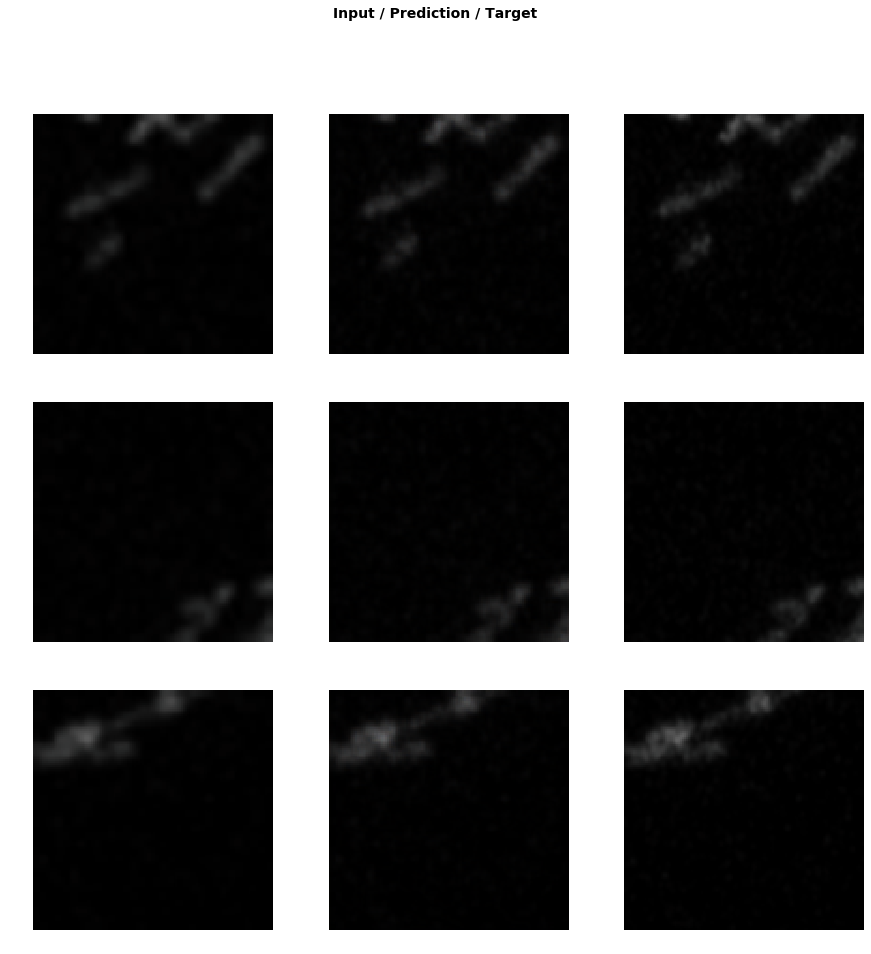

In [19]:
do_fit('movies_001.0', slice(lr*10))

In [20]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,0.624975,0.637552,0.018967,0.093671,0.107879,0.016954,0.136638,0.252875,0.010568
2,0.620627,0.636964,0.018939,0.093765,0.107821,0.016968,0.136196,0.252689,0.010586
3,0.621517,0.639458,0.019009,0.093761,0.107949,0.016975,0.138056,0.253122,0.010587
4,0.623173,0.636919,0.018943,0.093839,0.107832,0.016914,0.136677,0.252175,0.010539
5,0.617741,0.631638,0.019077,0.093994,0.107415,0.016851,0.133761,0.250032,0.010508
6,0.619543,0.635362,0.018754,0.093287,0.107354,0.016916,0.136828,0.251646,0.010577
7,0.618151,0.631816,0.018899,0.093123,0.106993,0.016876,0.133046,0.252327,0.010552
8,0.615895,0.633639,0.018967,0.093519,0.107379,0.016850,0.135100,0.251323,0.010502
9,0.614870,0.641708,0.019103,0.093941,0.108024,0.016855,0.139765,0.253520,0.010501
10,0.610822,0.622042,0.018807,0.093115,0.106479,0.016670,0.129759,0.246809,0.010402


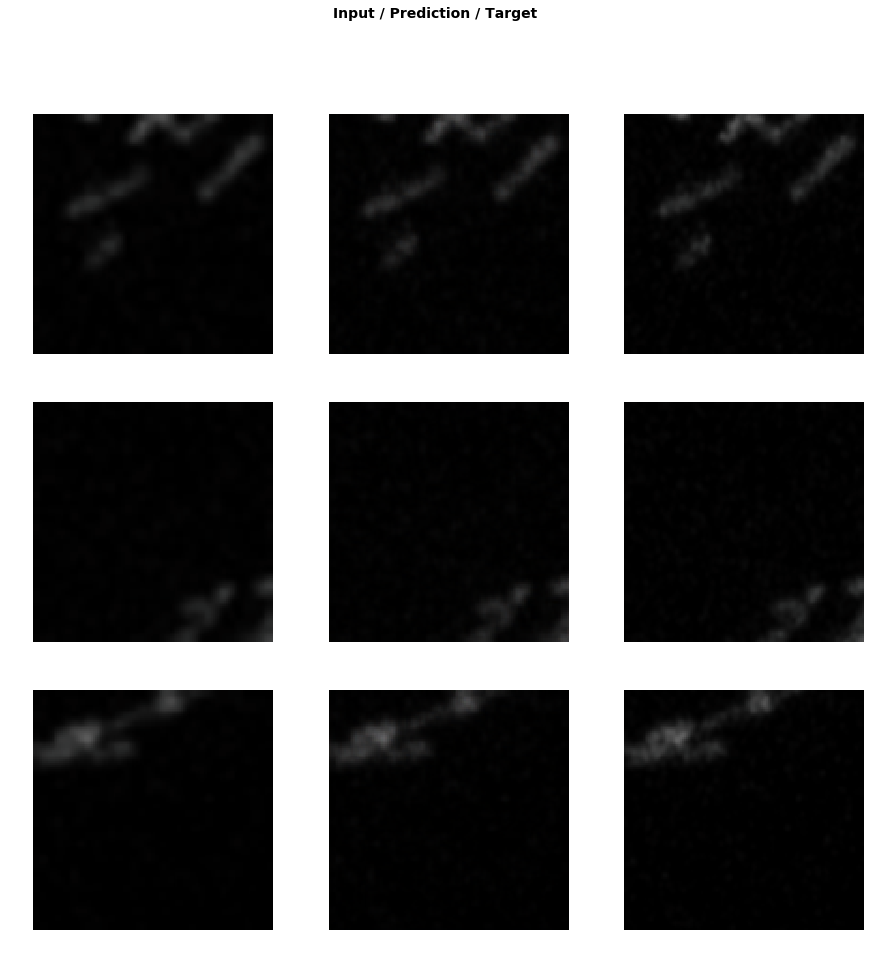

In [21]:
do_fit('movies_001.1', slice(1e-5,lr))